# Hands-On Optimization in Deep Learning @ MATH+ Summer School
Welcome to the Math+ summer school session on optimization in deep learning! In this notebook, we'll explore different optimization algorithms and their impact on training neural networks.

In the following, we will cover some of the most popular (first-order) optimization algorithms for training neural networks. We will use the [PyTorch](https://pytorch.org/) framework for this purpose. If you are not familiar with PyTorch, you can find a short introduction [here](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

We will focus on the following first-order optimization algorithms:
- Stochastic Gradient Descent (SGD)
- SGD with Momentum
- Nesterov Accelerated Gradient (NAG) or SGD with Nesterov Momentum
- Adaptive Gradient Algorithm (AdaGrad)
- Adaptive Moment Estimation (Adam)

# Setup
Before we start, we need to import some packages and define some helper functions. We will use the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database/) for our experiments. The MNIST dataset consists of 28x28 grayscale images of handwritten digits (0-9) and is a popular benchmark dataset for image classification. We will use the [torchvision](https://pytorch.org/docs/stable/torchvision/index.html) package to download the dataset.

1. **Preliminaries:** Install and import packages
2. **Data Preprocessing:** Prepare MNIST dataset
3. **Model Initialization:** Define Neural Network architecture (Multi-Layer Perceptron)
4. **Helper Functions:** Define training and evaluation functions
5. **Coding Exercise:** Code your own optimizers like msgd, SGD with Momentum, SGD with Nesterov Momentum, AdaGrad, Adam
6. **Train and Test:** Train and evaluate your model with your optimizers
6. **Evaluation:** Compare the different optimizers


# 1) Preliminaries: Installation and Imports

In [36]:
!pip3 install numpy matplotlib torch torchvision

In [37]:
# Setup: Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split


## 2) Data Preprocessing

Let's load and preprocess the MNIST dataset. 

- Normalization is important for convergence rates. We normalize the data to have approximately zero mean and unit variance.
- We also convert the labels to one-hot encoded vectors.
- Finally, we split the dataset into training and validation sets.
- We use the validation set to evaluate the model's performance on unseen data.

In [38]:
# Set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Transform data to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
dataset = MNIST(root='./data', download=True, transform=transform)

# Split the dataset into training, validation, and test sets
train_set, val_set = random_split(dataset, [50000, 10000])
test_set = MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

print(f"Training Samples: {len(train_set)}")
print(f"Validation Samples: {len(val_set)}")
print(f"Testing Samples: {len(test_set)}")

Training Samples: 50000
Validation Samples: 10000
Testing Samples: 10000


## 3) Model Initialization

Now, let's define a very simple feed-forward neural network to serve as our baseline model. This model consists of a single hidden layer with 128 neurons and a ReLU activation function. The output layer consists of 10 neurons, one for each class, and a softmax activation function.

In [94]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the model and move it to the device
model = SimpleNN().to(device)
print(model)

# Loop over the parameters
for name, param in model.named_parameters():
    print(f"Name: {name}, Shape: {param.shape}")

for param in model.parameters():
    print(param.shape)


SimpleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Name: fc1.weight, Shape: torch.Size([128, 784])
Name: fc1.bias, Shape: torch.Size([128])
Name: fc2.weight, Shape: torch.Size([10, 128])
Name: fc2.bias, Shape: torch.Size([10])
torch.Size([128, 784])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


## 4) Helper Functions: Training and Evaluation Routines

Let's first define our training and evaluation functions, which will be used later for training and evaluating our model. We will use the cross-entropy loss function, which is commonly used for classification problems. 

In [41]:
# Define the loss and metrics
criterion = nn.CrossEntropyLoss()

# Define the training function
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(dataloader.dataset)

# Define the evaluation function
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
    accuracy = correct_predictions / len(dataloader.dataset)
    return running_loss / len(dataloader.dataset), accuracy


# Gradient Descent Optimization Algorithms

As stated above, we will focus on the following first-order optimization algorithms:
- Stochastic Gradient Descent (SGD)
- SGD with Momentum
- Nesterov Accelerated Gradient (NAG) or SGD with Nesterov Momentum
- Adaptive Gradient Algorithm (AdaGrad)
- Adaptive Moment Estimation (Adam)

To understand the differences between these algorithms, let's first take a look at the vanilla Batch Gradient Descent algorithm.


## Batch Gradient Descent

Batch Gradient Descent is an iterative optimization algorithm used for minimizing a function. In the context of machine learning, this function is typically a loss function that measures the discrepancy between the predicted values of the model and the actual target values.

The basic idea is to update the model's parameters in the opposite direction of the gradient of the loss with respect to those parameters. The magnitude of this update is controlled by a hyperparameter called the learning rate.

<div style="text-align: center;">
<img src="imgs/Gradient_descent.png" width="300" height="300">
        <p>Image Source: https://en.wikipedia.org/wiki/Gradient_descent</p>

</div>

Mathematically, the update rule for each parameter $ \theta \in \mathbb{R}^n$ is given by
$$ \theta_{t+1} = \theta_t - \eta \nabla_{\theta} L(\theta_t) \, ,$$

where
- $\theta$ represents the model parameters.
- $ \eta \in \mathbb{R} $ is the learning rate.
- $ \nabla_{\theta} L(\theta) \in \mathbb{R}^n $ is the gradient of the loss function $L$ with respect to the model parameters.

## Stochastic Gradient Descent (SGD)

While Batch Gradient Descent uses the entire dataset to compute the gradient, Stochastic Gradient Descent (SGD) updates the parameters using only a single sample at each iteration. This makes SGD much faster and suitable for online learning. However, this results in many more updates with high variance, which can cause the loss to fluctuate heavily.

The word 'stochastic' means that the samples are randomly picked (or shuffled) for each iteration. Due to its stochastic nature, the path to the optimal solution may not be smooth as in the case of Gradient Descent, but it can escape shallow local minimums and saddle points, which can be beneficial for non-convex loss functions encountered in deep learning.

## Coding Exercise: Mini-Batch Gradient Descent

Mini-batch gradient descent is a variation of SGD where instead of a single sample, a mini-batch of samples is used at each iteration. This reduces the variance of the parameter updates, which can lead to more stable convergence. It can also take advantage of parallel computing hardware like GPUs, resulting in further speedup. Generally speaking, the mini-batch version tries to combine the advanteges of both batch gradient descent and SGD. 

The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. In deep learning, mini-batches are selected randomly from the training dataset. Although the correct terminology is to call the method "mini-batch gradient descent", most people simply call it "SGD". Therefore we will use the term SGD in the rest of this notebook.

Let's implement MySGD and see how it performs on a simple classification problem.

In [100]:
class MySGD:
    def __init__(self, params, lr):
        self.params = list(params) 
        self.lr = lr 

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

    def step(self):
        # 1. Loop over all parameters
        # 2. Update the parameters with SGD
        # Hint: use p.data and p.grad to access the parameter values and the gradient    

        for p in self.params:
            if p.grad is None:
                continue            
            p.data = p.data - self.lr * p.grad

        # The type of p is : <class 'torch.nn.parameter.Parameter'>
        # The type of p.grad is : <class 'torch.Tensor'> (representing the gradient of p)
        # The type of p.data is : <class 'torch.Tensor'>  (representing the value of p)


## Training our Model with MySGD

We will now train our model with MySGD on MNIST and evaluate its performance on the validation set. The results are stored in the respective lists and will be used for plotting later.

In [99]:
# Set hyperparameters
learning_rate = 0.01
num_epochs = 20

# Initialize model and optimizer
model_sgd = SimpleNN().to(device)
optimizer_sgd = MySGD(model_sgd.parameters(), lr=learning_rate) # Here we use our own SGD optimizer

# Train model
train_loss_sgd = []
val_loss_sgd = []
for epoch in range(num_epochs):
    loss = train_model(model_sgd, train_loader, optimizer_sgd, criterion, device)
    train_loss_sgd.append(loss)
    # Evaluate on validation set
    val_loss, val_accuracy = evaluate_model(model_sgd, val_loader, criterion, device)
    val_loss_sgd.append(val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

self.params: torch.Size([128, 784])
Epoch 1/20, Training Loss: 0.6160, Validation Loss: 0.3801, Validation Accuracy: 0.8881
Epoch 2/20, Training Loss: 0.3285, Validation Loss: 0.3262, Validation Accuracy: 0.9045
Epoch 3/20, Training Loss: 0.2863, Validation Loss: 0.2819, Validation Accuracy: 0.9194
Epoch 4/20, Training Loss: 0.2562, Validation Loss: 0.2637, Validation Accuracy: 0.9225
Epoch 5/20, Training Loss: 0.2297, Validation Loss: 0.2334, Validation Accuracy: 0.9367
Epoch 6/20, Training Loss: 0.2082, Validation Loss: 0.2146, Validation Accuracy: 0.9421
Epoch 7/20, Training Loss: 0.1894, Validation Loss: 0.2016, Validation Accuracy: 0.9443
Epoch 8/20, Training Loss: 0.1736, Validation Loss: 0.1889, Validation Accuracy: 0.9489
Epoch 9/20, Training Loss: 0.1598, Validation Loss: 0.1735, Validation Accuracy: 0.9542
Epoch 10/20, Training Loss: 0.1476, Validation Loss: 0.1708, Validation Accuracy: 0.9532
Epoch 11/20, Training Loss: 0.1368, Validation Loss: 0.1607, Validation Accuracy: 0

In [102]:
# NOTE: If you want to use pre-computed results, uncomment the following two lines

# train_loss_sgd = [0.6160, 0.3285, 0.2863, 0.2562, 0.2297, 0.2082, 0.1894, 0.1736, 0.1598, 0.1476, 0.1368, 0.1278, 0.1191, 0.1122, 0.1057, 0.0999, 0.0947, 0.0899, 0.0852, 0.0817]
# val_loss_sgd = [0.3801, 0.3262, 0.2819, 0.2637, 0.2334, 0.2146, 0.2016, 0.1889, 0.1735, 0.1708, 0.1607, 0.1504, 0.1450, 0.1370, 0.1343, 0.1308, 0.1250, 0.1215, 0.1176, 0.1186]

Great! At this point you should have obtained a validation accuracy of >90% with your (mini-batch) SGD implementation. If not, you can try to tune the hyperparameters (learning rate, batch size, number of epochs, etc.) to improve the performance. However the default values should be sufficient to obtain a reasonable accuracy. The initialization of the model parameters is also important for the final performance and is one of the reasons why we obtain different results when running the same code multiple times.

Given the simple nature of the MNIST dataset, (mini-batch) SGD is able to find a good solution in a reasonable amount of time. However, for more complex datasets, SGD may take a long time to converge. In the next section, we will look at momentum-based methods that can accelerate the convergence and improve the performance.


## A Leap Forward with Momentum

In the realm of optimization algorithms, _momentum_ is a technique that enhances Stochastic Gradient Descent (SGD) by providing it both speed and direction. The intuition is as follows: A ball with momentum gathers speed in directions where the slope is consistently steep while slowing down when faced with oscillations or noise.

<div style="text-align: center;">
    <table style="margin-left: auto; margin-right: auto;">
        <tr>
            <td style="text-align: center;">
                <img src="imgs/without_momentum.gif" width="250" height="100" />
                <br>
                <span>SGD without Momentum</span>
            </td>
            <td style="text-align: center;">
                <img src="imgs/with_momentum.gif" width="250" height="100" />
                <br>
                <span>SGD with Momentum</span>
            </td>
        </tr>
    </table>
        <p>This illustration taken from <a href="https://www.ruder.io/optimizing-gradient-descent/" target="_blank">[1]</a> depicts the key concept of <em>momentum</em>.</p>
</div>

It does this by adding a fraction $\gamma \in \mathbb{R}$ of the update vector of the past time step to the current update vector:

$$ v_{t+1} = \gamma v_t + \eta \nabla_{\theta} L(\theta_t) \, ,$$

$$ \theta_{t+1} = \theta_t - v_{t+1} \, ,$$

where:
- $\gamma$ is the momentum coefficient, usually set to values like 0.9 or 0.99. It dictates how much of the previous velocity is retained.
- $v_t \in \mathbb{R}^n$ is the velocity vector at time $t$, initially set to zero.
- $\eta$ is the learning rate, similar to SGD.
- $\nabla_{\theta} L(\theta_t) \in \mathbb{R}^n$ is the gradient of the loss function $L$ with respect to the model parameters.


\[1]: https://www.ruder.io/optimizing-gradient-descent/

## Coding Exercise: SGD with Momentum
Now that we understand the theory behind momentum, let's implement it from scratch. Your task is to fill in the missing lines of code to complete the implementation of the MyMomentumSGD class.


In [68]:
class MyMomentumSGD:
    def __init__(self, params, learning_rate=0.01, momentum=0.9):
        self.params = list(params)
        self.lr = learning_rate
        self.momentum = momentum
        self.velocity = [torch.zeros_like(p.data) for p in self.params if p is not None]
        
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def step(self):
        for i, param in enumerate(self.params):
            if param.grad is None:
                continue
            
            # Compute the velocity update
            self.velocity[i] = self.momentum * self.velocity[i] + self.lr * param.grad            
    
            # Update parameters
            param.data -= self.velocity[i]


## Training our Model with MyMomentumSGD

Let's train our model with our new optimizer and compare the results with MySGD.  

In [69]:
# Set hyperparameters
learning_rate = 0.01
num_epochs = 10

# Initialize model and optimizer
model_msgd = SimpleNN().to(device)
optimizer_msgd = MyMomentumSGD(model_msgd.parameters(), learning_rate=learning_rate) # Here we use our own SGD with Momentum

# Train model
train_loss_msgd = []
val_loss_msgd = []
for epoch in range(num_epochs):
    loss = train_model(model_msgd, train_loader, optimizer_msgd, criterion, device)
    train_loss_msgd.append(loss)
    
    val_loss, val_accuracy = evaluate_model(model_msgd, val_loader, criterion, device)
    val_loss_msgd.append(val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/10, Training Loss: 0.3418, Validation Loss: 0.2183, Validation Accuracy: 0.9355
Epoch 2/10, Training Loss: 0.1656, Validation Loss: 0.1511, Validation Accuracy: 0.9566
Epoch 3/10, Training Loss: 0.1215, Validation Loss: 0.1252, Validation Accuracy: 0.9614
Epoch 4/10, Training Loss: 0.0999, Validation Loss: 0.1301, Validation Accuracy: 0.9629
Epoch 5/10, Training Loss: 0.0831, Validation Loss: 0.1273, Validation Accuracy: 0.9643
Epoch 6/10, Training Loss: 0.0729, Validation Loss: 0.1165, Validation Accuracy: 0.9675
Epoch 7/10, Training Loss: 0.0655, Validation Loss: 0.1071, Validation Accuracy: 0.9678
Epoch 8/10, Training Loss: 0.0567, Validation Loss: 0.1055, Validation Accuracy: 0.9719
Epoch 9/10, Training Loss: 0.0513, Validation Loss: 0.1026, Validation Accuracy: 0.9698
Epoch 10/10, Training Loss: 0.0454, Validation Loss: 0.1092, Validation Accuracy: 0.9698


Great! Looks like the Momentum has a significant impact on our model's performance. We were able to improve the validation accuracy **by ~10%** by simply adding momentum to our SGD optimizer.

**Avoiding Redundant Computations:**
To spare you the effort of rerunning all experiments from scratch, we've provided the option to load pre-computed results below. Utilizing these saved metrics allows you to jump right into data analysis without any delay.

In [70]:
train_loss_msgd = [1.7359, 1.6258, 1.5641, 1.5390, 1.5283, 1.5205, 1.5144, 1.5092, 1.5052, 1.5021]
val_loss_msgd = [1.6359, 1.6219, 1.5547, 1.5392, 1.5304, 1.5233, 1.5183, 1.5132, 1.5123, 1.5087]

In [71]:
## Nesterov Momentum


## Our 2nd Optimization Algorithm: AdaGrad

AdaGrad, short for "Adaptive Gradient Algorithm," is an optimization algorithm designed to improve the performance and training speed of machine learning algorithms. Unlike SGD, which uses a constant learning rate for all parameters, AdaGrad adapts the learning rates during training. This can be particularly useful when dealing with sparse data or features that appear infrequently.

### How Does AdaGrad Work?

The key idea behind AdaGrad is to adjust the learning rates based on the past gradients for each parameter individually. Specifically, it keeps track of the sum of squares of past gradients and adjusts the learning rate in a way that is inversely proportional to the square root of this sum.

Mathematically, the AdaGrad update rule for each parameter $ \theta $ can be represented as:

$$
\begin{aligned}
g_t &= \nabla_{\theta} L(\theta_t) , \\
G_t &= G_{t-1} + g_t \odot g_t , \\
\theta_{t+1} &= \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \odot g_t
\end{aligned}
$$

Where:

- $ g_t $ represents the gradient of the loss function at time step $ t $.
- $ G_t $ is the diagonal matrix that stores the sum of squares of the past gradients.
- $ \odot $ represents element-wise multiplication.
- $ \epsilon $ is a smoothing term to prevent division by zero (usually set to a small value like $ 1 \times 10^{-8} $).
- $ \eta $ is the global learning rate.

### Why AdaGrad?

- Adaptive Learning Rate: AdaGrad adapts the learning rate during training. This can be beneficial for loss functions that have different shapes along different dimensions.
- Sparse Data: AdaGrad can perform well on problems with sparse features where the importance of each feature varies significantly. This is because rarely occurring features get a higher learning rate, thus AdaGrad can adapt quickly to more informative features.
- Simple and Easy to Implement: Similar to SGD, AdaGrad is easy to implement and computationally efficient.

However, it's worth noting that AdaGrad's aggressive decrease in the learning rate can be a double-edged sword. While it often performs well on convex problems, the continually decreasing learning rate can cause the algorithm to converge prematurely when optimizing non-convex functions, as often encountered in deep learning.

Now, let's experiment with AdaGrad and compare it against our previous results with SGD!

In [42]:
class MyAdaGrad:
    def __init__(self, params, lr=0.01, epsilon=1e-8):
        self.params = list(params)
        self.lr = lr
        self.epsilon = epsilon
        self.G = {}  # To store sum of squares of gradients for each parameter

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

    def step(self):
        for p in self.params:
            if p.grad is None:
                continue
            
            if p not in self.G:
                self.G[p] = torch.zeros_like(p.data)
            
            # Update sum of squares of gradients
            self.G[p] += p.grad.data ** 2
            
            # Update model parameters
            adjustment = self.lr / torch.sqrt(self.G[p] + self.epsilon)
            p.data.add_(-adjustment * p.grad.data)


In [43]:
# Set hyperparameters
learning_rate = 0.001

# Initialize model and optimizer
model_adagrad = SimpleNN().to(device)
# optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=learning_rate)
optimizer_adagrad = MyAdaGrad(model_adagrad.parameters(), lr=learning_rate)
# Train model
train_loss_adagrad = []
val_loss_adagrad = []
for epoch in range(num_epochs):
    loss = train_model(model_adagrad, train_loader, optimizer_adagrad, criterion, device)
    train_loss_adagrad.append(loss)
    
    val_loss, val_accuracy = evaluate_model(model_adagrad, val_loader, criterion, device)
    val_loss_adagrad.append(val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/10, Training Loss: 1.8393, Validation Loss: 1.7620, Validation Accuracy: 0.7366
Epoch 2/10, Training Loss: 1.7357, Validation Loss: 1.7036, Validation Accuracy: 0.8104
Epoch 3/10, Training Loss: 1.6753, Validation Loss: 1.6537, Validation Accuracy: 0.8620
Epoch 4/10, Training Loss: 1.6325, Validation Loss: 1.6237, Validation Accuracy: 0.8865
Epoch 5/10, Training Loss: 1.6147, Validation Loss: 1.6118, Validation Accuracy: 0.8895
Epoch 6/10, Training Loss: 1.6054, Validation Loss: 1.6040, Validation Accuracy: 0.8939
Epoch 7/10, Training Loss: 1.5991, Validation Loss: 1.5988, Validation Accuracy: 0.8961
Epoch 8/10, Training Loss: 1.5944, Validation Loss: 1.5948, Validation Accuracy: 0.8974
Epoch 9/10, Training Loss: 1.5906, Validation Loss: 1.5914, Validation Accuracy: 0.9002
Epoch 10/10, Training Loss: 1.5876, Validation Loss: 1.5889, Validation Accuracy: 0.9001


## Comparing Results

Let's plot the training and validation losses for SGD and AdaGrad and compare them.


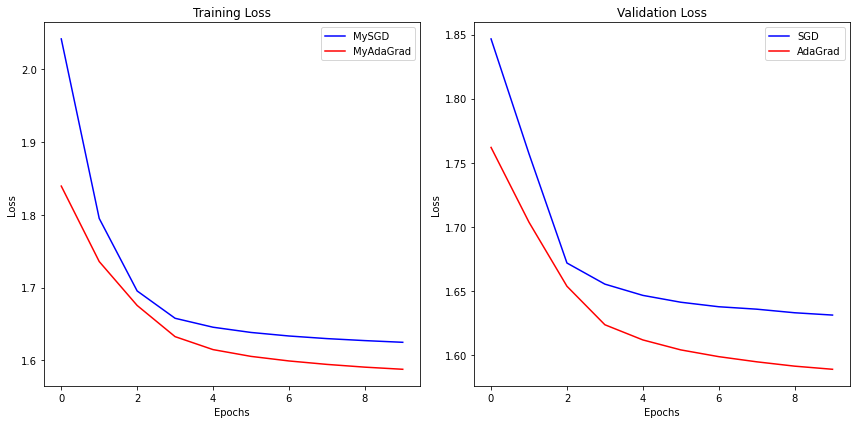

In [44]:
# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_sgd, label="MySGD", color='blue')
plt.plot(train_loss_adagrad, label="MyAdaGrad", color='red')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_loss_sgd, label="MySGD", color='blue')
plt.plot(val_loss_adagrad, label="MyAdaGrad", color='red')
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


Great! We can see that AdaGrad has a lower validation loss than SGD. This means that for our specific problem AdaGrad is able to generalize better than SGD.

## Our 3rd Optimization Algorithm: Adam

Adam, short for "Adaptive Moment Estimation," combines ideas from both Momentum and AdaGrad. It computes adaptive learning rates for each parameter and also maintains an exponentially decaying average of past gradients, similar to momentum.

Mathematically, the Adam update rule can be represented as:

$$
m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g_t 
$$
$$
v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g_t^2
$$
$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}
$$
$$
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$
$$
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \cdot \hat{m}_t
$$

Where:

- $g_t$ represents the gradient of the loss at time step $t$.
- $ m_t $ and $v_t$ are estimates of the first moment (the mean) and the second moment (the uncentered variance) of the gradients respectively.
- $\beta_1$ and $\beta_2$ are the forgetting factors for these moment estimates.
- $\hat{m}_t$ and $\hat{v}_t$ are bias-corrected estimates of the first and second moments.
- $\epsilon$ is a smoothing term to prevent division by zero (usually set to a small value like $1 \times 10^{-8}$).
- $ \eta$ is the learning rate.

In [53]:
class MyAdam:
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.t = 0
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()


    def step(self):
        self.t += 1
        for p, m, v in zip(self.params, self.m, self.v):
            if p.grad is None:
                continue
            grad = p.grad.data
            m.mul_(self.betas[0]).add_(grad, alpha=1 - self.betas[0])
            v.mul_(self.betas[1]).addcmul_(grad, grad, value=1 - self.betas[1])
            m_hat = m / (1 - self.betas[0] ** self.t)
            v_hat = v / (1 - self.betas[1] ** self.t)
            p.data.addcdiv_(m_hat, (v_hat.sqrt() + self.eps), value=-self.lr)
            
class MyAdam:
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.params = list(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}  # Placeholder for the first moment vector
        self.v = {}  # Placeholder for the second moment vector
        self.t = 0   # Initialize timestep

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        self.t += 1  # Increment timestep
        for p in self.params:
            if p.grad is None:
                continue
            
            # Initialize moment vectors if encountering this parameter for the first time
            if p not in self.m:
                self.m[p] = torch.zeros_like(p.data)
            if p not in self.v:
                self.v[p] = torch.zeros_like(p.data)

            # Update biased first and second moment estimates
            self.m[p] = self.beta1 * self.m[p] + (1 - self.beta1) * p.grad.data
            self.v[p] = self.beta2 * self.v[p] + (1 - self.beta2) * p.grad.data ** 2
            
            # Compute bias-corrected first and second moment estimates
            m_hat = self.m[p] / (1 - self.beta1 ** self.t)
            v_hat = self.v[p] / (1 - self.beta2 ** self.t)
            
            # Update the parameter
            p.data -= self.lr * m_hat / (torch.sqrt(v_hat) + self.epsilon)


### Start Training with MyAdam

In [54]:
# Set hyperparameters
learning_rate = 0.001

# Initialize model and optimizer
model_adam = SimpleNN().to(device)
# optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=learning_rate)
optimizer_adam = MyAdam(model_adam.parameters(), lr=learning_rate)
# Train model
train_loss_adam = []
val_loss_adam = []
for epoch in range(num_epochs):
    loss = train_model(model_adam, train_loader, optimizer_adam, criterion, device)
    train_loss_adam.append(loss)
    
    val_loss, val_accuracy = evaluate_model(model_adam, val_loader, criterion, device)
    val_loss_adam.append(val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/10, Training Loss: 1.6081, Validation Loss: 1.5643, Validation Accuracy: 0.9033
Epoch 2/10, Training Loss: 1.5459, Validation Loss: 1.5373, Validation Accuracy: 0.9303
Epoch 3/10, Training Loss: 1.5300, Validation Loss: 1.5244, Validation Accuracy: 0.9391
Epoch 4/10, Training Loss: 1.5190, Validation Loss: 1.5189, Validation Accuracy: 0.9444
Epoch 5/10, Training Loss: 1.5124, Validation Loss: 1.5251, Validation Accuracy: 0.9379
Epoch 6/10, Training Loss: 1.5071, Validation Loss: 1.5087, Validation Accuracy: 0.9534
Epoch 7/10, Training Loss: 1.5026, Validation Loss: 1.5104, Validation Accuracy: 0.9520
Epoch 8/10, Training Loss: 1.5001, Validation Loss: 1.5074, Validation Accuracy: 0.9544
Epoch 9/10, Training Loss: 1.4981, Validation Loss: 1.5072, Validation Accuracy: 0.9550
Epoch 10/10, Training Loss: 1.4954, Validation Loss: 1.5003, Validation Accuracy: 0.9614


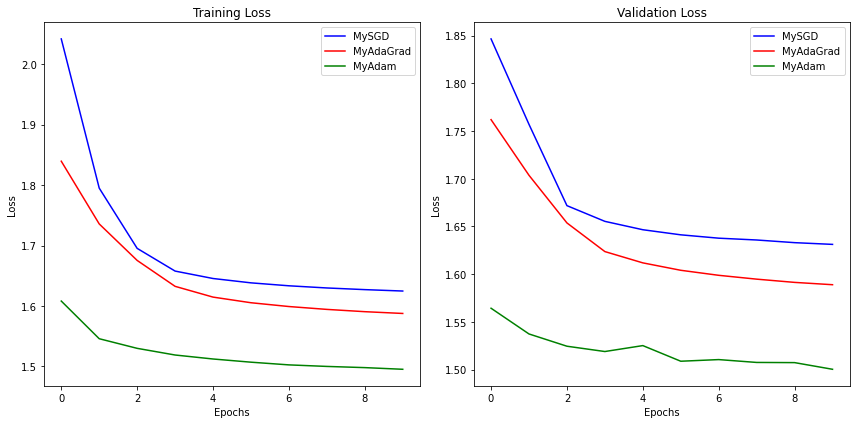

In [55]:
# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_sgd, label="MySGD", color='blue')
plt.plot(train_loss_adagrad, label="MyAdaGrad", color='red')
plt.plot(train_loss_adam, label="MyAdam", color='green')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_loss_sgd, label="MySGD", color='blue')
plt.plot(val_loss_adagrad, label="MyAdaGrad", color='red')
plt.plot(val_loss_adam, label="MyAdam", color='green')
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


# Conclusion

In this notebook, we learned about different optimization algorithms and their impact on training neural networks. We also implemented these algorithms from scratch and compared their performance on the MNIST dataset. 

# References

- Overview: [An overview of gradient descent optimization algorithms](https://www.ruder.io/optimizing-gradient-descent/) by Sebastian Ruder ([arXiv version](https://arxiv.org/pdf/1609.04747.pdf))
- AdaGrad: [Adaptive Subgradient Methods for Online Learning and Stochastic Optimization](https://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf) by Duchi et al.
- [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980) by Kingma et al.
- [CS231n: Optimization Algorithms](https://cs231n.github.io/optimization-1/) - Stanford Course
- [CS231n: Neural Networks Part 2](https://cs231n.github.io/neural-networks-2/) - Stanford Course
- [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) by  François Chollet 
- [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow et al.